**420-A59-SF - Algorithmes d'apprentissage par renforcement - Automne 2020 - Spécialisation technique en Intelligence Artificielle**<br/>

# Travail de session

- Jean-Sébastien Parent
- 13 novembre 2020

**Contexte**
Dans l'application Atari "breakout-ram-v0", apprendre à un algorithme à jouer et obtenir les plus grands scores possibles.

<div class="alert alert-info">
<i class="fa fa-info-circle"></i> Mise en place de l'environnement de base
</div>

In [1]:
#!python --version

In [2]:
#!pip install tensorflow-gpu==1.15.4
#!pip install pandas 
#!pip install tqdm
#!pip install gym 
#!pip install gym[atari]
#!pip install Box2D -q

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Librairies

In [2]:
import sys
from collections import deque
import random
import numpy as np
import gym
import time
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
# Cacher les différents warning un peu partout
tf.get_logger().setLevel('ERROR')

In [4]:
# Validation de la version de tensorflow
tf.__version__

'1.15.4'

In [5]:
# Validation GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18420009661799617668
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3141979342
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15079115754096109750
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Interface Agent

In [6]:
class Agent(object):  
        
    def __init__(self, actions):
        self.actions = actions
        self.num_actions = 0 if actions == None else len(actions)
        self.log_buffer = ""
        
    def act(self, state):
        raise NotImplementedError
        
    def getModelFilename(self):
        raise NotImplementedError
    
    def saveModel(self):
        raise NotImplementedError
    
    def loadModel(self):
        raise NotImplementedError
        
    def log(self, message, doPrint = True, flushBuffer = False):
        """
        Enregistrement d'un log
        """
        if doPrint:
            print(message)
        
        self.log_buffer += message + "\n"
        
        if flushBuffer or len(self.log_buffer) > 1000:
            filename = self.getModelFilename() + ".log"
            with open(filename, "a", encoding="utf-8") as myfile:
                myfile.write(self.log_buffer)
            self.log_buffer = ""
            
    def isCancelRequested(self):
        """
        Vérifier si une annulation a été demandée 
        """
        return (os.path.isfile('./stop.txt'))

### Agent DQN

In [7]:
class DQNAgent(Agent):
    """Deep Q-Learning agent"""

    def __init__(self, actions, obs_size, qn, **kwargs):
        super(DQNAgent, self).__init__(actions)
       
        
        # Taille de S
        self.obs_size = obs_size
        
        # Description de notre modèle (essais)
        self.description = kwargs.get('description', 'defaut')
        
        # Epsilon
        self.epsilon = kwargs.get('epsilon', .01)       
        # Si epsilon = 1, décroissance progressive
        if self.epsilon == 1:
            self.epsilon_decay = True
        else:
            self.epsilon_decay = False
        
        # Facteur de dévaluation
        self.gamma = kwargs.get('gamma', .99)
        
        # Hyperparamètres des réseaux de neurones (modèle et cible)
        self.batch_size = kwargs.get('batch_size', 64)
        self.epoch_length = kwargs.get('epoch_length', 100)
        self.lr = kwargs.get('learning_rate', .0001)
        self.tau = kwargs.get('tau', .05)
        
        # Instanciation des réseaux de neurones (modèle et cible)
        self.model_network = qn
        self.target_network = tf.keras.models.clone_model(qn)
        
        # Charger les modèles déjà entraînés, s'ils existent
        self.loadModel()
        self.target_network.set_weights(self.model_network.get_weights()) 

        # Mémoire pour replay
        self.memory  = deque(maxlen=kwargs.get('mem_size', 1000000))
    
        self.step_counter = 0
    
    def act(self, state):    
        if np.random.random() < self.epsilon:
            i = np.random.randint(0,len(self.actions))
        else: 
            i = np.argmax(self.model_network.predict(state.reshape(1, state.shape[0]))[0])
                     
        self.step_counter += 1 
        #self.epsilon = max(.01, self.epsilon * .996)
        
        # decay epsilon after each epoch
        if self.epsilon_decay:
            if self.step_counter % self.epoch_length == 0 and self.epsilon > 0.01:
                #print(self.epsilon)
                self.epsilon = max(.01, self.epsilon * .975)
                #self.log(f"(Agent) self.epsilon rendu à {self.epsilon}")
        
        action = self.actions[i]        
        return action
    
    def learn(self, state1, action1, reward, state2, done):
        """
        Apprentissage: Mémorisation -> Replay -> Mise-à-jour Target
        """
        
        # Démarrer l'entraînement après 1 epoch
        if self.step_counter <= self.epoch_length:
            return
        
        # Sauvegarde la transition dans la mémoire de replay
        self.remember(state1, action1, reward, state2, done)
        
        # Experience replay
        self.replay()       
        
        # Mise-à-jour du modèle cible
        self.target_train() 

        
    def remember(self, state1, action1, reward, state2, done):
        """
        Sauvegarde la transition dans la mémoire de replay
        """
        self.memory.append([state1, action1, reward, state2, done])
    
    def replay(self):
        # Taille de la mémoire de replay insuffisante
        if len(self.memory) < self.batch_size: 
            return

        minibatch = random.sample(self.memory, self.batch_size)
        
        # Implémentation séquentielle (inutilisable sur mon environnement, 1 épisode aux 30 secondes)
        #for state1, action1, reward, state2, done in minibatch:
        #    target = self.target_network.predict(state1.reshape(1, state1.shape[0]))
        #    if done:
        #        target[0][action1] = reward
        #    else:
        #        Q_future = max(self.target_network.predict(state2.reshape(1, state2.shape[0]))[0])
        #        target[0][action1] = reward + self.gamma * Q_future
        #    
        #    self.model_network.fit(state1.reshape(1, state1.shape[0]), target, epochs=1, verbose=0)
            
        # Implémentation parallèle
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.target_network.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.target_network.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model_network.fit(states, targets_full, epochs=1, verbose=0)
        
        # L'enregistrement du modèle se fera dans la simulation plutôt, pour éviter de ralentir le processus
        #self.saveModel()
            
            
    def target_train(self):
        """
        Mise-à-jour des poids du réseau de neurones "cible"
        """
        model_weights = self.model_network.get_weights()
        target_weights = self.target_network.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * model_weights[i] + (1 - self.tau) * target_weights[i]
        self.target_network.set_weights(target_weights)
        
    def getModelFilename(self):
        return f"./runs/Breakout-jsparent.dqn.model_{self.description}.h5"
    
    def saveModel(self):
        """
        Enregistrement du modèle
        """
        self.log(f"(Agent) Mise à jour du fichier modèle")
        self.model_network.save(self.getModelFilename())
    
    def loadModel(self):
        """
        Chargement du modèle
        """
        # Charger le fichier en mémoire, s'il existe
        self.log("")
        self.log("--------------------------------------------------------")
        try:
            existing_model = tf.keras.models.load_model(self.getModelFilename())
            self.model_network = existing_model
            self.log(f"(Agent) Modèle '{self.getModelFilename()}' chargé avec succès")
        except:
            self.log(f"(Agent) Modèle '{self.getModelFilename()}' n'existe pas, création d'un nouveau modèle")
        
        self.log("Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier")
        self.log("--------------------------------------------------------")
        
        if (os.path.isfile('./stop.txt')):
            os.rename('stop.txt', 'stop-.txt')

### Agent ActorCritic

In [8]:
class ActorCriticAgent(Agent):
    def __init__(self, observation_space, actions_space, alpha, beta, gamma=0.99,
                 hidden1=1024, hidden2=512, description=""):
        super(ActorCriticAgent, self).__init__(None) # Hack
        self.observation_space = observation_space
        self.state_size = observation_space.shape[0]
        self.action_space = actions_space
        self.num_actions = actions_space.n

        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.description = description
        
        self.actor, self.critic, self.policy = self.build_actor_critic_network()
            
        self.render = False

    def build_actor_critic_network(self):
        inpt = Input(shape=(self.state_size,))
        delta = Input(shape=[1])
        dense1 = Dense(self.hidden1, activation='relu')(inpt)
        dense2 = Dense(self.hidden2, activation='relu')(dense1)
        probs = Dense(self.num_actions, activation='softmax')(dense2)
        values = Dense(1, activation='linear')(dense2)

        def custom_loss(y_true, y_pred):
            out = tf.keras.backend.clip(y_pred, 1e-8, 1-1e-8)
            log_likelihood = y_true*tf.keras.backend.log(out)

            return tf.keras.backend.sum(-log_likelihood*delta)

        actor = Model(inputs=[inpt, delta], outputs=[probs])
        critic = Model(inputs=[inpt], outputs=[values])
       
        self.loadModel()
        
        actor.compile(optimizer=Adam(lr=self.alpha), loss=custom_loss)
        critic.compile(optimizer=Adam(lr=self.beta), loss='mean_squared_error')
        
        policy = Model(inputs=[inpt], outputs=[probs])

        return actor, critic, policy

    def act(self, observation):
        state = observation[np.newaxis, :]
        probabilities = self.policy.predict(state)[0]
        action = np.random.choice(self.num_actions, p=probabilities)

        return action

    def learn(self, state, action, reward, state_, done):
        
        # Compléter le code ~ 10 lignes de code. Pour vous aider, voici les étapes
        
            # 1. Vérifier shape de state et state_ et ajuster si besoin
            state = state[np.newaxis, :]
            state_ = state_[np.newaxis, :]
            
            # 2. Effectuer prédictions sur state et state_ (Utiliser le critic)
            critic_value_ = self.critic.predict(state_)
            critic_value = self.critic.predict(state)
            
            # 3. Calculer le target: reward + gamma * critic_value_ * (1-done)
            target = reward + self.gamma * critic_value_ * (1-int(done))
            
            # 4. Calculer le delta (ou avantage): target - critic_value
            delta = target - critic_value
        
            # 5. Encoder les actions sous forme de label
            actions = np.zeros([1, self.num_actions])
            actions[np.arange(1), action] = 1
            
            # 6. Entraîner l'actor
            self.actor.fit([state, delta], actions, verbose=0)
            
            # 7. Entraîner le critic
            self.critic.fit(state, target, verbose=0)
            
    def getModelFilename(self):
        return f"./runs/Breakout-jsparent.ac.model_{self.description}.h5"
    
    def getModelFilenameActor(self):
        return f"./runs/Breakout-jsparent.ac.model_{self.description}_actor.h5"
    
    def getModelFilenameCritic(self):
        return f"./runs/Breakout-jsparent.ac.model_{self.description}_critic.h5"
    
    def saveModel(self):
        """
        Enregistrement des modèles
        """
        self.log(f"(Agent) Mise à jour des fichiers modèle")
        self.actor.save(self.getModelFilenameActor())  
        self.critic.save(self.getModelFilenameCritic())    
    
    def loadModel(self):
        """
        Chargement des modèles
        """
        # Charger le fichier en mémoire, s'il existe
        self.log("")
        self.log("--------------------------------------------------------")
        try:
            actor_filename = self.getModelFilenameActor()
            existing_model_actor = tf.keras.models.load_model(actor_filename, compile=False)
            self.actor = existing_model_actor
            self.log(f"(Agent) Modèle '{actor_filename}' chargé avec succès")
        except BaseException as e:
            self.log("\t*** " + str(e))
            self.log(f"(Agent) Modèle '{actor_filename}' n'existe pas, création d'un nouveau modèle")
        
        try:
            critic_filename = self.getModelFilenameCritic()
            existing_model_critic = tf.keras.models.load_model(critic_filename)
            self.critic = existing_model_critic
            self.log(f"(Agent) Modèle '{critic_filename}' chargé avec succès")
        except BaseException as e:
            self.log("\t*** " + str(e))
            self.log(f"(Agent) Modèle '{critic_filename}' n'existe pas, création d'un nouveau modèle")
        
       
        self.log("Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier")
        self.log("--------------------------------------------------------")
        
        if (os.path.isfile('./stop.txt')):
            os.rename('stop.txt', 'stop-.txt')

### Architecture neuronale et fonctions d'aide

In [9]:
def SetInteractive(interactive):
    if interactive == True:
        %matplotlib nbagg
    else:
        %matplotlib inline
    return interactive

In [10]:
def QNetwork(obs_size, num_actions, nhidden, lr):

    model = Sequential()
    model.add(Dense(nhidden, input_dim=obs_size, activation=relu))
    model.add(Dense(nhidden, activation=relu))
    model.add(Dense(num_actions, activation=linear))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(lr=lr))
    
    return model

# Breakout

In [11]:
env = gym.make("Breakout-ram-v0")

In [12]:
DO_REPLAY = True # Mode replay

In [13]:
from simulation import Experiment

### Test 1 - 2 couches de 150 neurones, LR=0.0001 et Tau=0.05


--------------------------------------------------------
(Agent) Modèle './runs/Breakout-jsparent.dqn.model_Test1_2couchesX150_lr0.0001_tau0.05.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


<IPython.core.display.Javascript object>


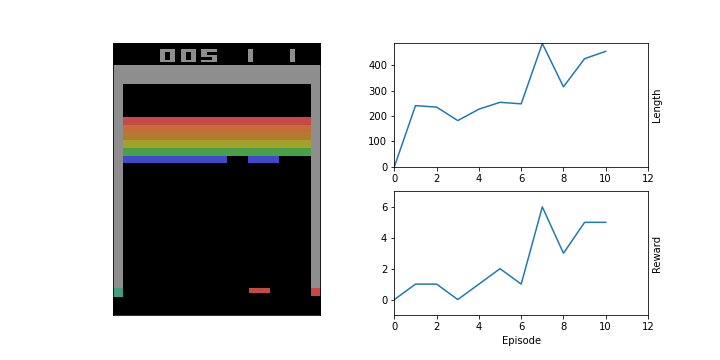

--------------------------------------------------------
Nouvelle séquence de 10 épisodes, débutée le 2020-11-29 12:57:26...
--------------------------------------------------------
> Mode REPLAY
	Nouveau meilleur score à: 1.0, épisode #1
	Nouveau meilleur score à: 2.0, épisode #5
	Nouveau meilleur score à: 6.0, épisode #7

Fin des épisodes
Meilleur score obtenu: 6.0
Durée moyenne: 279.0 actions
Score moyen: 2.27 points

- Temps de traitement: 2.8 minutes
--------------------------------------------------------



In [16]:
start_time = time.time()
interactive = SetInteractive(True)
desc = 'Test1_2couchesX150_lr0.0001_tau0.05'
obs_size = env.observation_space.shape[0]
actions = range(env.action_space.n)
num_actions = len(actions)
batch_size = 64
epoch_length = 100 # Au lieu de 100, car epsilon devenait à son minimum trop vite, ~250 parties à 1 vie
learning_rate = .0001
tau = .05
gamma = 0.99
episodes = 10 #2500

qn = QNetwork(obs_size, num_actions, nhidden=150, lr=learning_rate)
agent = DQNAgent(actions, 
                 obs_size=env.observation_space.shape[0], 
                 qn=qn, 
                 epsilon=1, 
                 description=desc,
                 batch_size=batch_size,
                 epoch_length=epoch_length, 
                 learning_rate=learning_rate,
                 gamma=gamma,
                 tau=tau)
experiment = Experiment(env, agent, EPISODES=episodes, training=not DO_REPLAY)
experiment.run_qlearning(interactive=interactive, save_model_each_n_episodes=25)

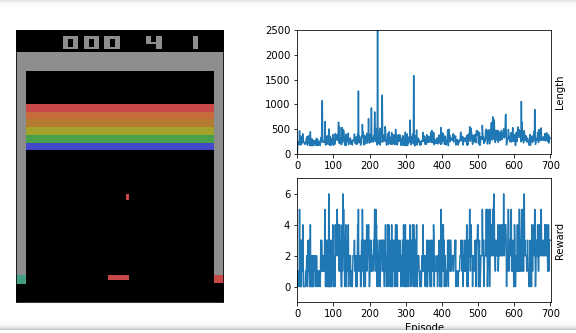

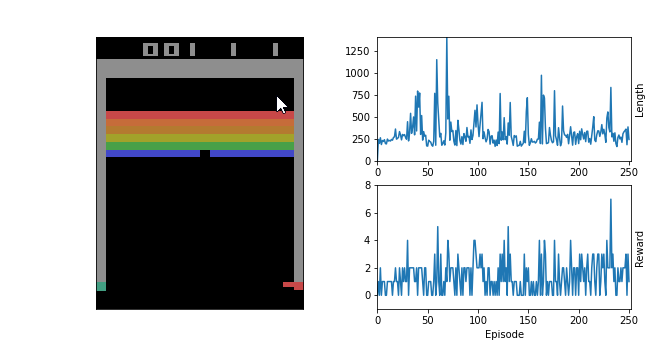

#### Ici, j'ai recommencé l'entrainement mais en introduisant le concept de récompense négative sur perte de vie
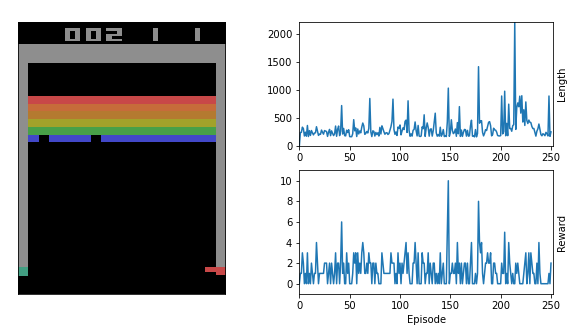

#### Ici, j'ai recommencé l'entrainement mais en introduisant le concept de récompense négative sur perte de vie à -100 par perte et aussi en ne changeant pas juste le reward pour -100, mais en le réduisant de 100, ce qui garde les projections quand même

- À noter que je suis reparti du modèle partiellement entraîné précédent

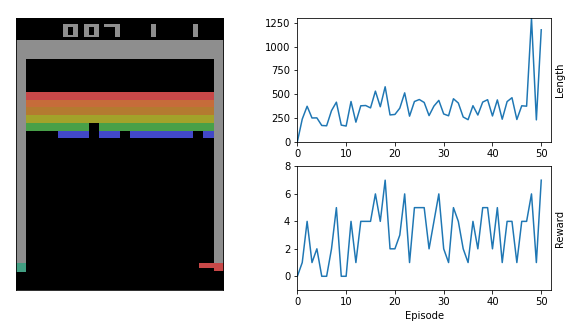

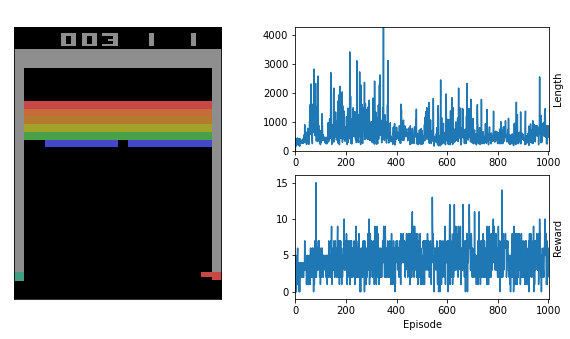

### Ici, j'ai recommencé en utilisant un modèle 1 vie = 1 épisode, et en alterant le score (0) et les vies (5) passées à l'algorithme pour ses fonction act() et learn()

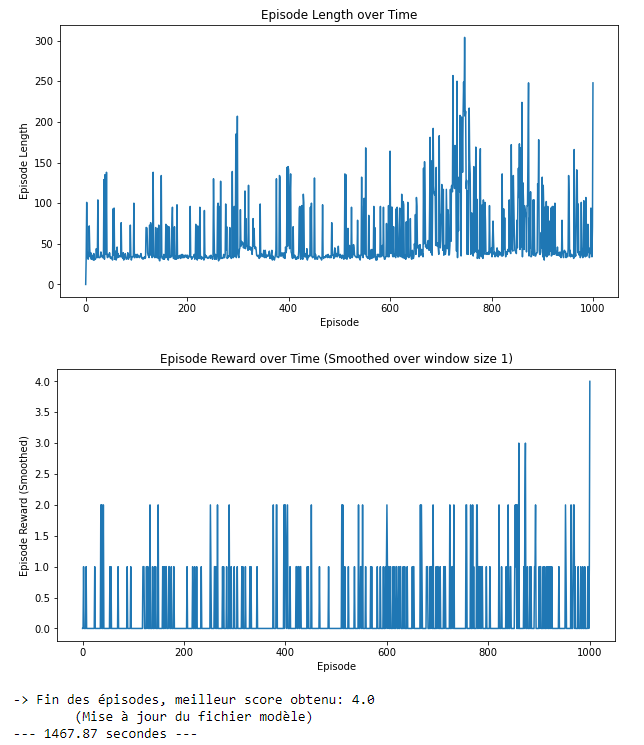

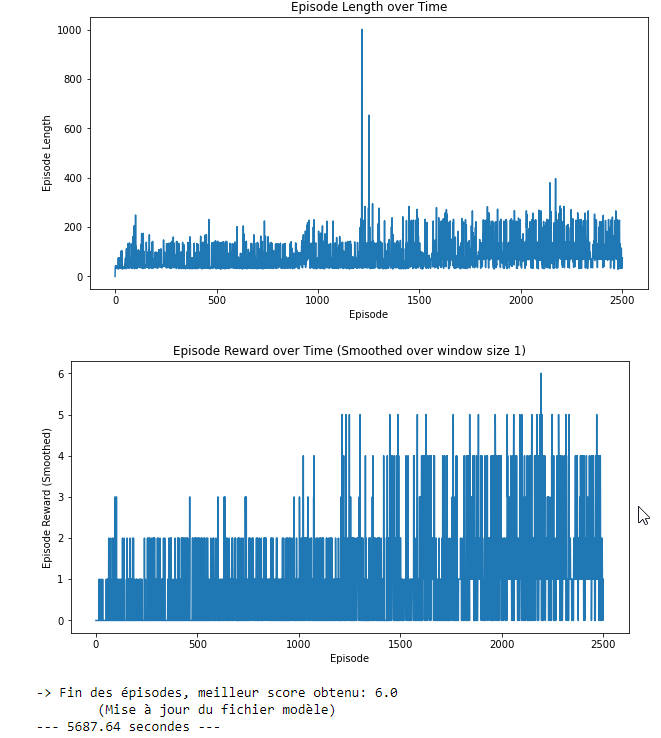

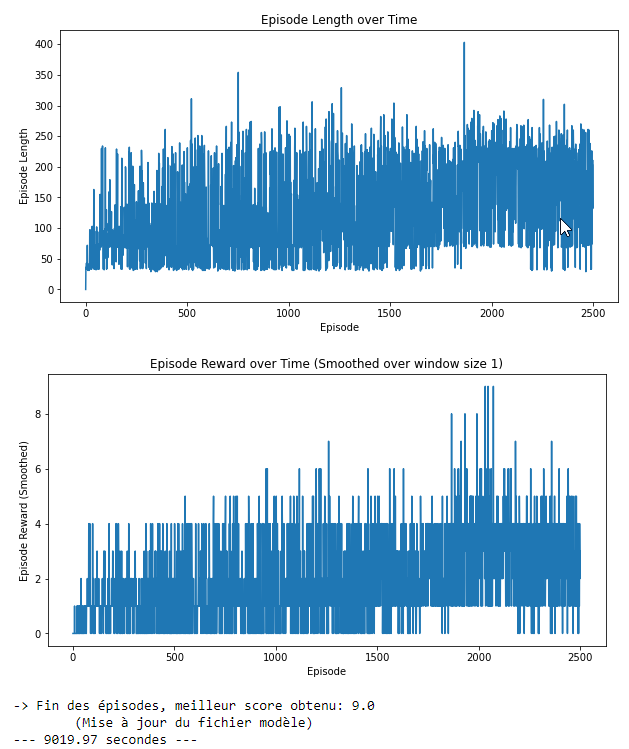

### Test 2 - 2 couches de 128 neurones, LR=0.00015, Tau=0.075, batch_size de 1024, epoch de 10000

In [15]:
from simulation import Experiment


--------------------------------------------------------
(Agent) Modèle './runs/Breakout-jsparent.dqn.model_Test1_2couchesX128_lr0.00015_tau0.075.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


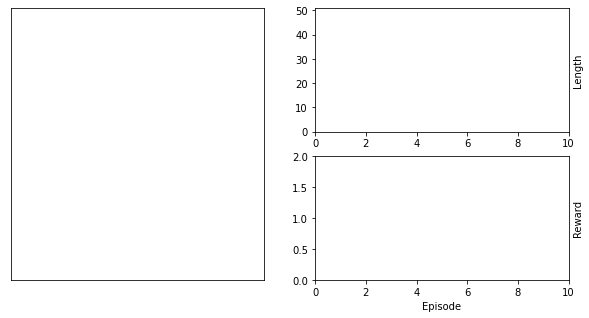

In [16]:
start_time = time.time()
interactive = SetInteractive(False)
desc = 'Test1_2couchesX128_lr0.00015_tau0.075'
obs_size = env.observation_space.shape[0]
actions = range(env.action_space.n)
num_actions = len(actions)
batch_size = 128 # Au lieu de 64, probablement, potentiellement trop bas
epoch_length = 1000 # Au lieu de 100, car epsilon devenait à son minimum trop vite, ~10 parties à 1 vie
learning_rate = .00015
tau = .075 # Au lieu de 0.05
gamma = 0.99
episodes = 2500

qn = QNetwork(obs_size, num_actions, nhidden=128, lr=learning_rate)
agent = DQNAgent(actions, 
                 obs_size=env.observation_space.shape[0], 
                 qn=qn, 
                 epsilon=1, 
                 description=desc,
                 batch_size=batch_size,
                 epoch_length=epoch_length, 
                 learning_rate=learning_rate,
                 gamma=gamma,
                 tau=tau)
experiment = Experiment(env, agent, EPISODES=episodes, training=not DO_REPLAY)
#experiment.run_qlearning(interactive=interactive, save_model_each_n_episodes=25)

#### Premier essai avec les nouveaux paramètres
Ici, l'epoch était à 10000, ce qui semble trop élevé pour apprendre et le batch_size était à 1000. On voit que ça n'a pas appris beaucoup.
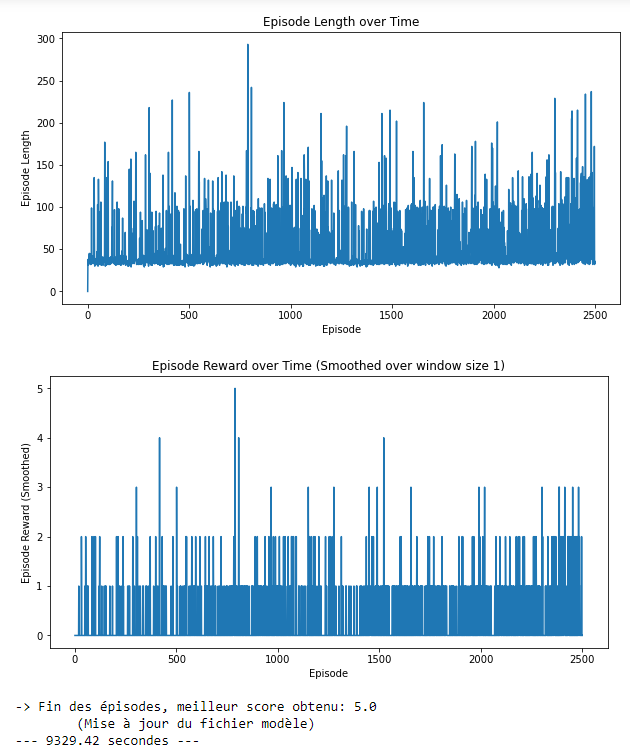

## 2e essai, pas super non plus
epoch à 1000 et batch_size à 128
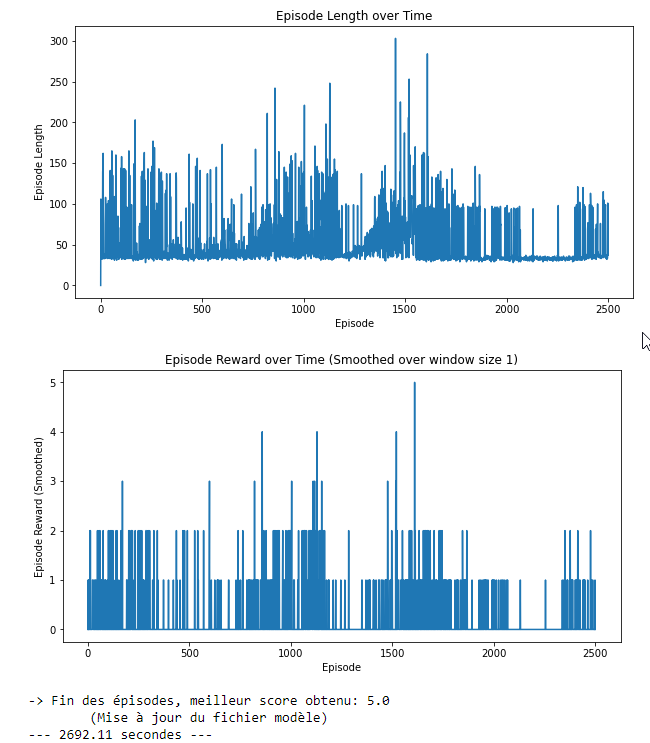

### Test 3 - 2 couches de 128 neurones, LR=0.0001, Tau=0.0¸5, batch_size de 128, epoch de 500

In [17]:
from simulation import Experiment


--------------------------------------------------------
(Agent) Modèle './runs/Breakout-jsparent.dqn.model_Test_2couchesX128_lr0.0001_tau0.05_batch128_epoch500.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


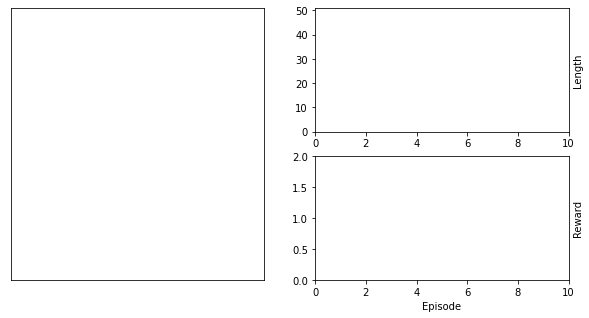

In [18]:
interactive = SetInteractive(False)
desc = 'Test_2couchesX128_lr0.0001_tau0.05_batch128_epoch500'
obs_size = env.observation_space.shape[0]
actions = range(env.action_space.n)
num_actions = len(actions)
batch_size = 128 # Au lieu de 64, probablement, potentiellement trop bas
epoch_length = 500 # Au lieu de 100, car epsilon devenait à son minimum trop vite, ~10 parties à 1 vie
learning_rate = .0001
tau = .05 # Au lieu de 0.05
gamma = 0.99
epsilon = 0.01 # Première run à 1, mais comme on veut continuer, on va le capper tout de suite
neurones = 128
episodes = 10000

qn = QNetwork(obs_size, num_actions, nhidden=neurones, lr=learning_rate)
agent = DQNAgent(actions, 
                 obs_size=env.observation_space.shape[0], 
                 qn=qn, 
                 epsilon=epsilon, 
                 description=desc,
                 batch_size=batch_size,
                 epoch_length=epoch_length, 
                 learning_rate=learning_rate,
                 gamma=gamma,
                 tau=tau)
experiment = Experiment(env, agent, EPISODES=episodes, training=not DO_REPLAY)
#experiment.run_qlearning(interactive=interactive, save_model_each_n_episodes=25)

### Tentative 1, intéressant, on voit les scores (par vie) augmenter jusqu'à 7 points, en progression constante
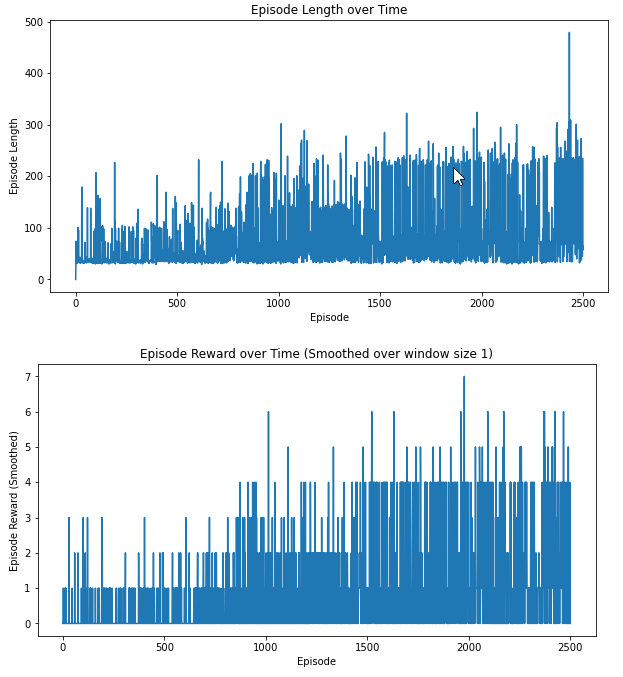

En continuant l'entrainement, on voit que ça stagne
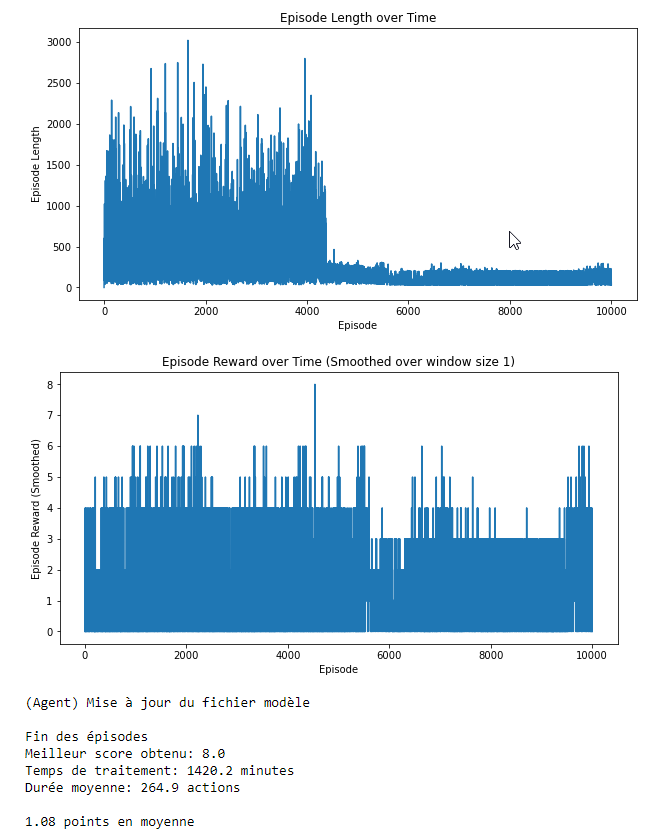

# Essai avec 4 couches de neurones, à 1 vie toujours

In [54]:
def QNetwork4(obs_size, num_actions, nhidden, lr):

    model = Sequential()
    model.add(Dense(nhidden, input_dim=obs_size, activation=relu))
    model.add(Dense(nhidden, activation=relu))
    model.add(Dense(nhidden, activation=relu))
    model.add(Dense(nhidden, activation=relu))
    model.add(Dense(num_actions, activation=linear))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(lr=lr))
    
    return model


--------------------------------------------------------
(Agent) Modèle './runs/Breakout-jsparent.dqn.model_Test_4couchesX128_lr0.0001_tau0.003_batch128_epoch1000.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


<IPython.core.display.Javascript object>


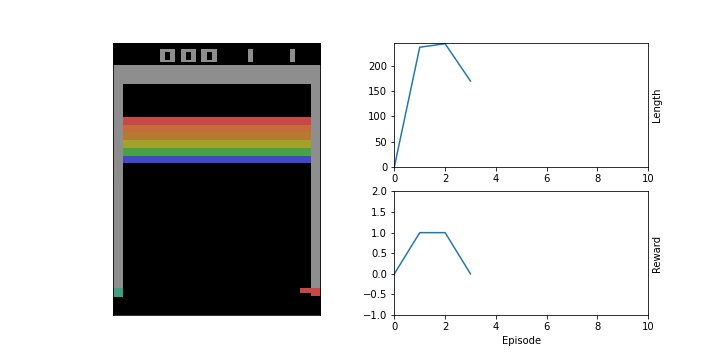

--------------------------------------------------------
Nouvelle séquence de 3 épisodes, débutée le 2020-11-27 19:43:57...
--------------------------------------------------------
> Mode REPLAY
	Nouveau meilleur score à: 1.0, épisode #1

Fin des épisodes
Meilleur score obtenu: 1.0
Durée moyenne: 162.8 actions
Score moyen: 0.5 points

- Temps de traitement: 0.7 minutes
--------------------------------------------------------



In [56]:
interactive = SetInteractive(True)
desc = 'Test_4couchesX128_lr0.0001_tau0.003_batch128_epoch1000'
obs_size = env.observation_space.shape[0]
actions = range(env.action_space.n)
num_actions = len(actions)
batch_size = 128 # Au lieu de 64, probablement, potentiellement trop bas
epoch_length = 1000 # Au lieu de 100, car epsilon devenait à son minimum trop vite, ~10 parties à 1 vie
learning_rate = .0001
tau = .003 # Au lieu de 0.05
gamma = 0.99
epsilon = 1 # Première run à 1, mais comme on veut continuer, on va le capper tout de suite
neurones = 128
episodes = 3 #10000

qn = QNetwork4(obs_size, num_actions, nhidden=neurones, lr=learning_rate)
agent = DQNAgent(actions, 
                 obs_size=env.observation_space.shape[0], 
                 qn=qn, 
                 epsilon=epsilon, 
                 description=desc,
                 batch_size=batch_size,
                 epoch_length=epoch_length, 
                 learning_rate=learning_rate,
                 gamma=gamma,
                 tau=tau)
experiment = Experiment(env, agent, EPISODES=episodes, training=not DO_REPLAY)
experiment.run_qlearning(interactive=interactive, save_model_each_n_episodes=25)

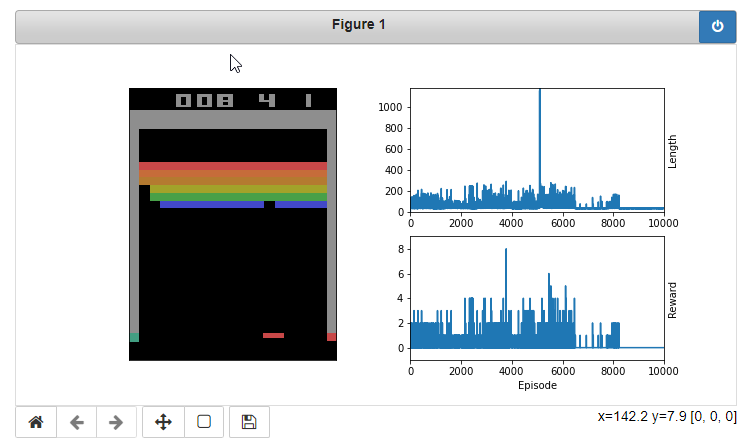

Fin des épisodes

Meilleur score obtenu: 8.0

Temps de traitement: 293.1 minutes

Durée moyenne: 47.7 actions

0.19 points en moyenne

# Essai avec 4 couches de neurons, à parties complètes

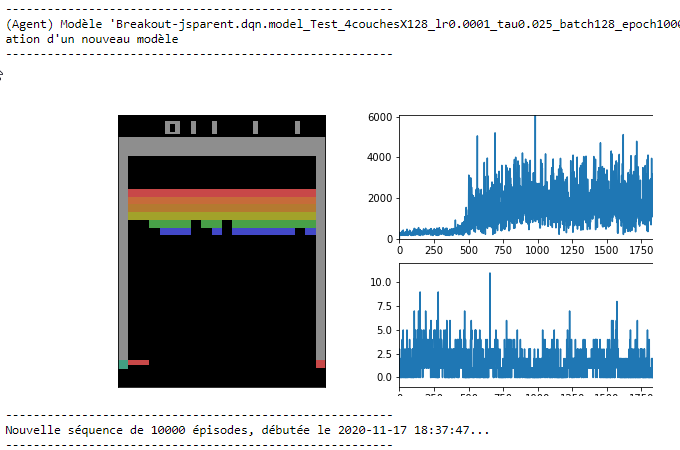

# Essai avec 2 couches de neurons, à parties complètes
Ici, par contre, on pénalise la perte de vie de -100 et l'inaction de -0.01

In [31]:
# On switch en mode cpu
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU - Bref plein de drôles d'erreurs CUDA en mode GPU passé ce point

In [51]:
from simulation import Experiment


--------------------------------------------------------
(Agent) Modèle './runs/Breakout-jsparent.dqn.model_Test_2couchesX128_lr0.0001_tau0.025_batch128_epoch1000_5_vies_AVEC_PÉNALITÉS.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


<IPython.core.display.Javascript object>


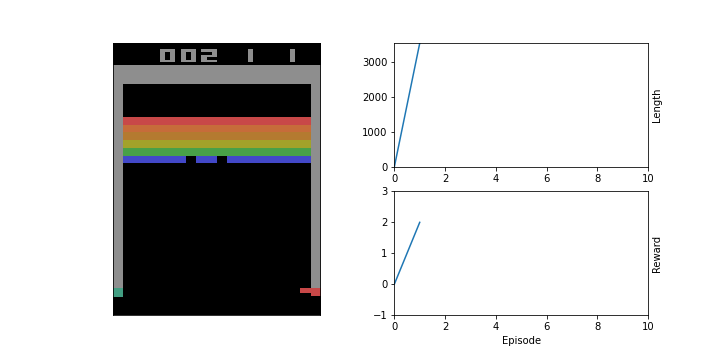

--------------------------------------------------------
Nouvelle séquence de 1 épisodes, débutée le 2020-11-27 19:02:19...
--------------------------------------------------------
> Mode REPLAY
	Nouveau meilleur score à: 2.0, épisode #1

Fin des épisodes
Meilleur score obtenu: 2.0
Durée moyenne: 1768.0 actions
Score moyen: 1.0 points

- Temps de traitement: 3.9 minutes
--------------------------------------------------------



In [52]:
interactive = SetInteractive(True)
desc = 'Test_2couchesX128_lr0.0001_tau0.025_batch128_epoch1000_5_vies_AVEC_PÉNALITÉS'
obs_size = env.observation_space.shape[0]
actions = range(env.action_space.n)
num_actions = len(actions)
batch_size = 128 # Au lieu de 64, probablement, potentiellement trop bas
epoch_length = 1000 # Au lieu de 100, car epsilon devenait à son minimum trop vite, ~10 parties à 1 vie
learning_rate = .0001
tau = .025 # Au lieu de 0.05
gamma = 0.99
epsilon = 0.01 # Première run à 1, mais comme on veut continuer, on va le capper tout de suite
neurones = 128
episodes = 1 # 1000

qn = QNetwork(obs_size, num_actions, nhidden=neurones, lr=learning_rate)
agent = DQNAgent(actions, 
                 obs_size=env.observation_space.shape[0], 
                 qn=qn, 
                 epsilon=epsilon, 
                 description=desc,
                 batch_size=batch_size,
                 epoch_length=epoch_length, 
                 learning_rate=learning_rate,
                 gamma=gamma,
                 tau=tau)
experiment = Experiment(env, agent, EPISODES=episodes, training = not DO_REPLAY)
experiment.run_qlearning(interactive=interactive, 
                         display_frequency=20, 
                         save_model_each_n_episodes=25)

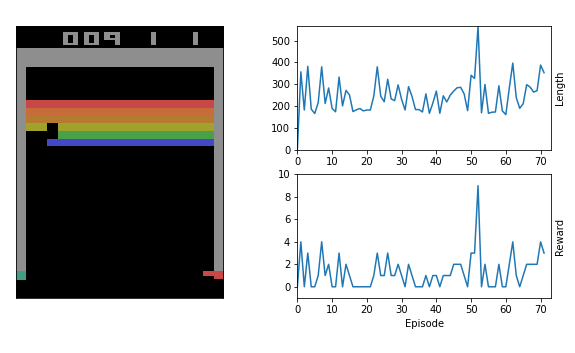

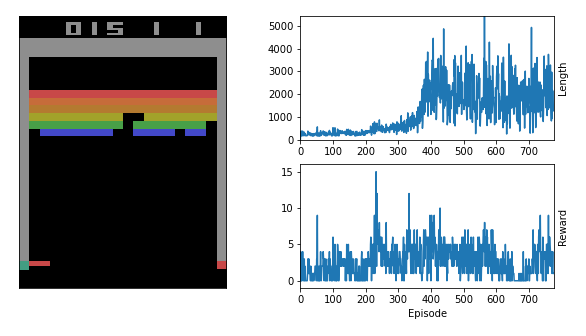

- Fin des épisodes
- Meilleur score obtenu: 15.0
- Temps de traitement: 421.3 minutes
- Durée moyenne: 1232.0 actions
- 2.74 points en moyenne

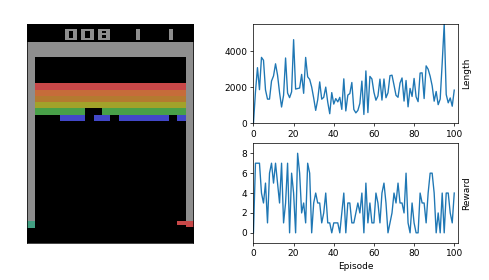
- Fin des épisodes
- Meilleur score obtenu: 8.0
- Temps de traitement: 71.2 minutes
- Durée moyenne: 1904.8 actions
- Score moyen: 2.92 points

# Essai avec 2 couches de neurons, à parties complètes
Ici, par contre, on pénalise la perte de vie de -100 et l'inaction de -0.01

In [25]:
from simulation import Experiment

In [26]:
interactive = SetInteractive(True)
desc = 'Test_2couchesX128_lr0.0001_tau0.05_batch64_epoch1001_5_vies_AVEC_PÉNALITÉS'
obs_size = env.observation_space.shape[0]
actions = range(env.action_space.n)
num_actions = len(actions)
batch_size = 64 # Au lieu de 64, probablement, potentiellement trop bas
epoch_length = 100 # Au lieu de 100, car epsilon devenait à son minimum trop vite, ~10 parties à 1 vie
learning_rate = .0001
tau = .05 # Au lieu de 0.05
gamma = 0.99
epsilon = 1 # Première run à 1, mais comme on veut continuer, on va le capper tout de suite
neurones = 128
episodes = 100

qn = QNetwork(obs_size, num_actions, nhidden=neurones, lr=learning_rate)
agent = DQNAgent(actions, 
                 obs_size=env.observation_space.shape[0], 
                 qn=qn, 
                 epsilon=epsilon, 
                 description=desc,
                 batch_size=batch_size,
                 epoch_length=epoch_length, 
                 learning_rate=learning_rate,
                 gamma=gamma,
                 tau=tau)
#experiment = Experiment(env, agent, EPISODES=episodes)
#experiment.run_qlearning(interactive=interactive, 
#                         display_frequency=20, 
#                         save_model_each_n_episodes=25,
#                        time_penalty=0.01,
#                         life_penalty=100)


--------------------------------------------------------
(Agent) Modèle 'Breakout-jsparent.dqn.model_Test_2couchesX128_lr0.0001_tau0.05_batch64_epoch1001_5_vies_AVEC_PÉNALITÉS.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


In [27]:
interactive = SetInteractive(True)
desc = 'Test_2couchesX128_lr0.0001_tau0.05_batch64_epoch1001_5_vies_AVEC_PÉNALITÉS'
obs_size = env.observation_space.shape[0]
actions = range(env.action_space.n)
num_actions = len(actions)
batch_size = 64 # Au lieu de 64, probablement, potentiellement trop bas
epoch_length = 100 # Au lieu de 100, car epsilon devenait à son minimum trop vite, ~10 parties à 1 vie
learning_rate = .0001
tau = .05 # Au lieu de 0.05
gamma = 0.99
epsilon = 1 # Première run à 1, mais comme on veut continuer, on va le capper tout de suite
neurones = 128
episodes = 100

qn = QNetwork(obs_size, num_actions, nhidden=neurones, lr=learning_rate)
agent = DQNAgent(actions, 
                 obs_size=env.observation_space.shape[0], 
                 qn=qn, 
                 epsilon=epsilon, 
                 description=desc,
                 batch_size=batch_size,
                 epoch_length=epoch_length, 
                 learning_rate=learning_rate,
                 gamma=gamma,
                 tau=tau)
#experiment = Experiment(env, agent, EPISODES=2)
#experiment.run_qlearning(interactive=interactive, 
#                         display_frequency=20, 
#                         save_model_each_n_episodes=25,
#                        time_penalty=0.01,
#                        life_penalty=100)


--------------------------------------------------------
(Agent) Modèle 'Breakout-jsparent.dqn.model_Test_2couchesX128_lr0.0001_tau0.05_batch64_epoch1001_5_vies_AVEC_PÉNALITÉS.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


# Avec A3C

In [15]:
# On switch en mode cpu
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU - Bref plein de drôles d'erreurs CUDA en mode GPU passé ce point

In [29]:
# Désactivation du mode eager de Tensoflow (> 2.0)
tf.compat.v1.disable_eager_execution()

In [40]:
from simulation import Experiment

In [43]:
# Instanciation de l'agent REINFORCE
desc = 'alpha0.0001_beta0.0005_gamma0.99_32-32'
interactive = SetInteractive(True)
agent = ActorCriticAgent(observation_space=env.observation_space,
                       actions_space=env.action_space,
                       alpha = 0.0001,
                       beta = 0.0005,
                       gamma = 0.99,
                       hidden1 = 32,
                       hidden2 = 32,
                       description = desc)

# Lancement de l'expérience
experiment = Experiment(env, agent,
    EPISODES=5000,
    training=True,
    episode_max_length=1000,
    mean_episodes=100,
    stop_criterion=125)
#experiment.run_actorcritic()


--------------------------------------------------------
(Agent) Modèle 'Breakout-jsparent.a3c.model_alpha0.0001_beta0.0005_gamma0.99_32-32_actor.h5' chargé avec succès
(Agent) Modèle 'Breakout-jsparent.a3c.model_alpha0.0001_beta0.0005_gamma0.99_32-32_critic.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


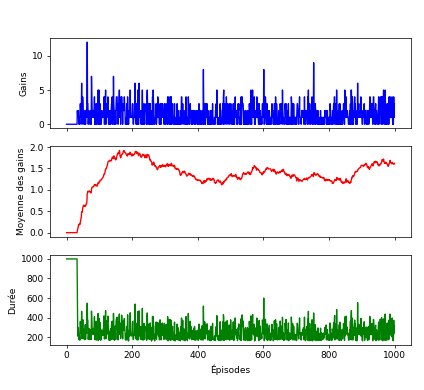

Fin des épisodes
- Meilleur score obtenu: 12.0
- Durée moyenne: 278.8 actions
- Score moyen: 1.42 points

(Agent) Mise à jour des fichiers modèle
- Temps de traitement: 87.5 minutes

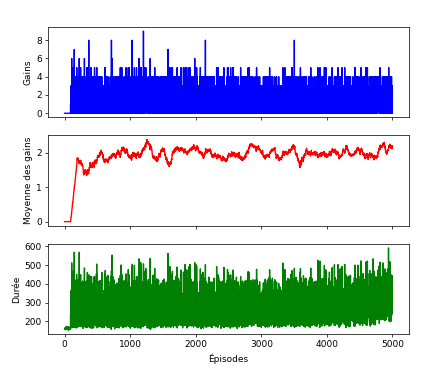

Fin des épisodes
- Meilleur score obtenu: 9.0
- Durée moyenne: 289.4 actions
- Score moyen: 1.92 points

(Agent) Mise à jour des fichiers modèle
- Temps de traitement: 468.5 minutes

In [46]:
# Instanciation de l'agent REINFORCE
desc = 'alpha0.0001_beta0.0005_gamma0.95_32-32'
interactive = SetInteractive(True)
agent = ActorCriticAgent(observation_space=env.observation_space,
                       actions_space=env.action_space,
                       alpha = 0.0001,
                       beta = 0.0005,
                       gamma = 0.95,
                       hidden1 = 32,
                       hidden2 = 32,
                       description = desc)

# Lancement de l'expérience
experiment = Experiment(env, agent,
    EPISODES=1000,
    training=True,
    episode_max_length=1000,
    mean_episodes=100,
    stop_criterion=125)
#experiment.run_actorcritic()


--------------------------------------------------------
(Agent) Modèle 'Breakout-jsparent.a3c.model_alpha0.0001_beta0.0005_gamma0.95_32-32_actor.h5' chargé avec succès
(Agent) Modèle 'Breakout-jsparent.a3c.model_alpha0.0001_beta0.0005_gamma0.95_32-32_critic.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


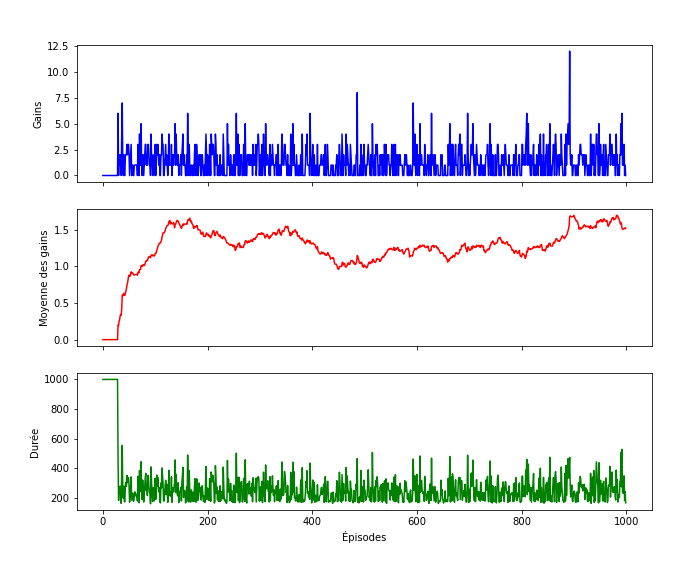

Fin des épisodes
- Meilleur score obtenu: 12.0
- Durée moyenne: 269.7 actions
- Score moyen: 1.32 points

(Agent) Mise à jour des fichiers modèle
- Temps de traitement: 89.9 minutes

In [48]:
# Instanciation de l'agent REINFORCE
desc = 'alpha0.0001_beta0.0005_gamma0.8_32-32'
interactive = SetInteractive(True)
agent = ActorCriticAgent(observation_space=env.observation_space,
                       actions_space=env.action_space,
                       alpha = 0.0001,
                       beta = 0.0005,
                       gamma = 0.8,
                       hidden1 = 32,
                       hidden2 = 32,
                       description = desc)

# Lancement de l'expérience
experiment = Experiment(env, agent,
    EPISODES=1000,
    training=True,
    episode_max_length=1000,
    mean_episodes=100,
    stop_criterion=125)
#experiment.run_actorcritic()


--------------------------------------------------------
(Agent) Modèle 'Breakout-jsparent.a3c.model_alpha0.0001_beta0.0005_gamma0.8_32-32_actor.h5' chargé avec succès
(Agent) Modèle 'Breakout-jsparent.a3c.model_alpha0.0001_beta0.0005_gamma0.8_32-32_critic.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


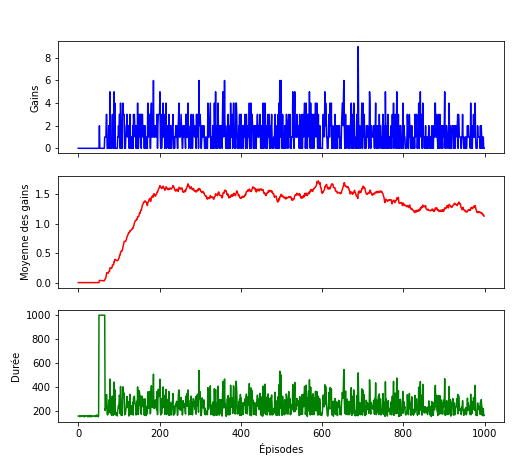

Fin des épisodes
- Meilleur score obtenu: 9.0
- Durée moyenne: 259.0 actions
- Score moyen: 1.34 points

(Agent) Mise à jour des fichiers modèle
- Temps de traitement: 88.6 minutes

In [50]:
# Instanciation de l'agent REINFORCE
desc = 'alpha0.001_beta0.005_gamma0.99_32-32'
interactive = SetInteractive(True)
agent = ActorCriticAgent(observation_space=env.observation_space,
                       actions_space=env.action_space,
                       alpha = 0.001,
                       beta = 0.005,
                       gamma = 0.99,
                       hidden1 = 32,
                       hidden2 = 32,
                       description = desc)

# Lancement de l'expérience
experiment = Experiment(env, agent,
    EPISODES=1000,
    training=True,
    episode_max_length=1000,
    mean_episodes=100,
    stop_criterion=125)
#experiment.run_actorcritic()


--------------------------------------------------------
(Agent) Modèle 'Breakout-jsparent.a3c.model_alpha0.001_beta0.005_gamma0.99_32-32_actor.h5' chargé avec succès
(Agent) Modèle 'Breakout-jsparent.a3c.model_alpha0.001_beta0.005_gamma0.99_32-32_critic.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


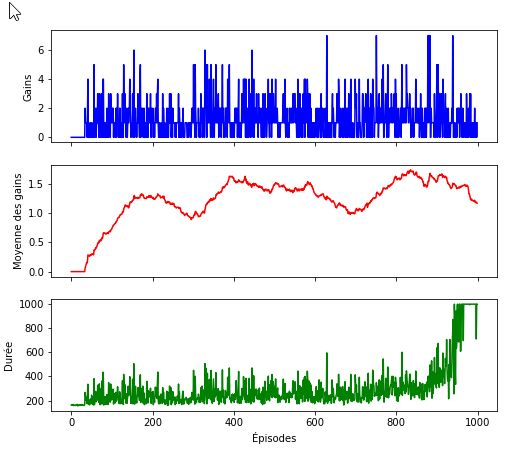
Fin des épisodes
- Meilleur score obtenu: 7.0
- Durée moyenne: 302.3 actions
- Score moyen: 1.27 points

(Agent) Mise à jour des fichiers modèle
- Temps de traitement: 113.8 minutes

In [55]:
# Instanciation de l'agent REINFORCE
desc = 'alpha0.01_beta0.05_gamma0.99_32-32'
interactive = SetInteractive(True)
agent = ActorCriticAgent(observation_space=env.observation_space,
                       actions_space=env.action_space,
                       alpha = 0.01,
                       beta = 0.05,
                       gamma = 0.99,
                       hidden1 = 32,
                       hidden2 = 32,
                       description = desc)

# Lancement de l'expérience
experiment = Experiment(env, agent,
    EPISODES=1000,
    training=True,
    episode_max_length=1000,
    mean_episodes=100,
    stop_criterion=125)
#experiment.run_actorcritic()


--------------------------------------------------------
(Agent) Modèle './runs/Breakout-jsparent.ac.model_alpha0.01_beta0.05_gamma0.99_32-32_actor.h5' chargé avec succès
(Agent) Modèle './runs/Breakout-jsparent.ac.model_alpha0.01_beta0.05_gamma0.99_32-32_critic.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


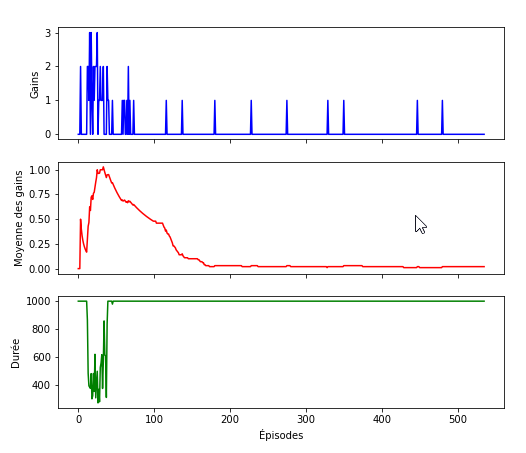

Fin des épisodes
- Meilleur score obtenu: 3.0
- Durée moyenne: 974.0 actions
- Score moyen: 0.11 points

(Agent) Mise à jour des fichiers modèle
- Temps de traitement: 193.2 minutes

In [57]:
# Instanciation de l'agent REINFORCE
desc = 'alpha0.0001_beta0.001_gamma0.99_32-32'
interactive = SetInteractive(True)
agent = ActorCriticAgent(observation_space=env.observation_space,
                       actions_space=env.action_space,
                       alpha = 0.0001,
                       beta = 0.001,
                       gamma = 0.99,
                       hidden1 = 32,
                       hidden2 = 32,
                       description = desc)

# Lancement de l'expérience
experiment = Experiment(env, agent,
    EPISODES=1000,
    training=True,
    episode_max_length=1000,
    mean_episodes=100,
    stop_criterion=125)
#experiment.run_actorcritic()


--------------------------------------------------------
(Agent) Modèle './runs/Breakout-jsparent.ac.model_alpha0.0001_beta0.001_gamma0.99_32-32_actor.h5' chargé avec succès
(Agent) Modèle './runs/Breakout-jsparent.ac.model_alpha0.0001_beta0.001_gamma0.99_32-32_critic.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


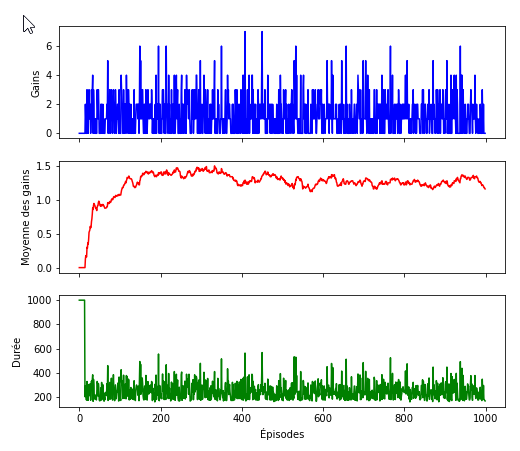
Fin des épisodes
- Meilleur score obtenu: 7.0
- Durée moyenne: 259.3 actions
- Score moyen: 1.26 points

(Agent) Mise à jour des fichiers modèle
- Temps de traitement: 105.3 minutes

In [59]:
# Instanciation de l'agent REINFORCE
desc = 'alpha0.001_beta0.0001_gamma0.99_32-32'
interactive = SetInteractive(True)
agent = ActorCriticAgent(observation_space=env.observation_space,
                       actions_space=env.action_space,
                       alpha = 0.001,
                       beta = 0.0001,
                       gamma = 0.99,
                       hidden1 = 32,
                       hidden2 = 32,
                       description = desc)

# Lancement de l'expérience
experiment = Experiment(env, agent,
    EPISODES=1000,
    training=True,
    episode_max_length=1000,
    mean_episodes=100,
    stop_criterion=125)
#experiment.run_actorcritic()


--------------------------------------------------------
(Agent) Modèle './runs/Breakout-jsparent.ac.model_alpha0.001_beta0.0001_gamma0.99_32-32_actor.h5' chargé avec succès
(Agent) Modèle './runs/Breakout-jsparent.ac.model_alpha0.001_beta0.0001_gamma0.99_32-32_critic.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


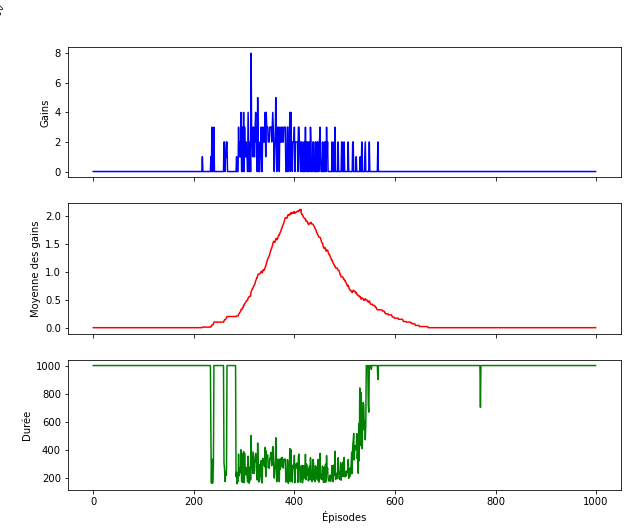
Fin des épisodes
- Meilleur score obtenu: 8.0
- Durée moyenne: 806.0 actions
- Score moyen: 0.35 points

(Agent) Mise à jour des fichiers modèle
- Temps de traitement: 286.8 minutes

In [61]:
# Instanciation de l'agent REINFORCE
desc = 'alpha0.0005_beta0.005_gamma0.99_32-32'
interactive = SetInteractive(True)
agent = ActorCriticAgent(observation_space=env.observation_space,
                       actions_space=env.action_space,
                       alpha = 0.0005,
                       beta = 0.005,
                       gamma = 0.99,
                       hidden1 = 32,
                       hidden2 = 32,
                       description = desc)

# Lancement de l'expérience
experiment = Experiment(env, agent,
    EPISODES=1000,
    training=True,
    episode_max_length=1000,
    mean_episodes=100,
    stop_criterion=125)
#experiment.run_actorcritic()


--------------------------------------------------------
(Agent) Modèle './runs/Breakout-jsparent.ac.model_alpha0.0005_beta0.005_gamma0.99_32-32_actor.h5' chargé avec succès
(Agent) Modèle './runs/Breakout-jsparent.ac.model_alpha0.0005_beta0.005_gamma0.99_32-32_critic.h5' chargé avec succès
Pour arrêter l'agent, créez un fichier 'stop.txt' dans le dossier
--------------------------------------------------------


# Références et lectures ayant menées à ce travail

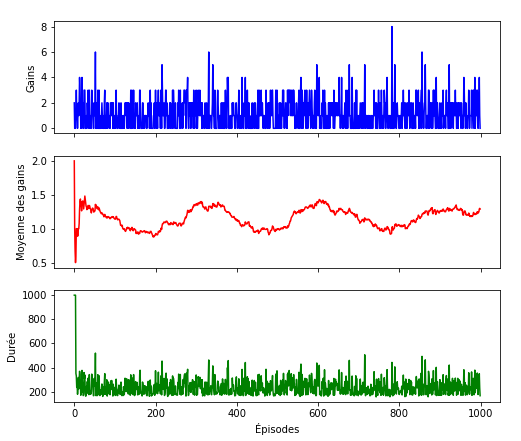

Fin des épisodes
- Meilleur score obtenu: 8.0
- Durée moyenne: 239.2 actions
- Score moyen: 1.16 points

(Agent) Mise à jour des fichiers modèle
- Temps de traitement: 89.9 minutes

In [ ]:
# Instanciation de l'agent REINFORCE
desc = 'alpha0.0001_beta0.01_gamma0.99_32-32'
interactive = SetInteractive(True)
agent = ActorCriticAgent(observation_space=env.observation_space,
                       actions_space=env.action_space,
                       alpha = 0.0001,
                       beta = 0.01,
                       gamma = 0.99,
                       hidden1 = 32,
                       hidden2 = 32,
                       description = desc)

# Lancement de l'expérience
experiment = Experiment(env, agent,
    EPISODES=1000,
    training=True,
    episode_max_length=1000,
    mean_episodes=100,
    stop_criterion=125)
#experiment.run_actorcritic()

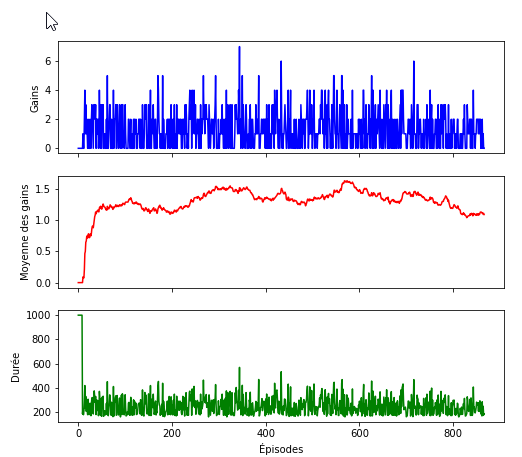
Fin des épisodes
- Meilleur score obtenu: 7.0
- Durée moyenne: 256.3 actions
- Score moyen: 1.31 points

(Agent) Mise à jour des fichiers modèle
- Temps de traitement: 85.8 minutes

- https://gym.openai.com/envs/Breakout-ram-v0/
- https://deepsense.ai/playing-atari-on-ram-with-deep-q-learning/
- http://cs229.stanford.edu/proj2016/report/BonillaZengZheng-AsynchronousDeepQLearningforBreakout-Report.pdf
- https://towardsdatascience.com/tutorial-double-deep-q-learning-with-dueling-network-architectures-4c1b3fb7f756
- https://keras.io/examples/rl/deep_q_network_breakout/
- https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26
- https://becominghuman.ai/beat-atari-with-deep-reinforcement-learning-part-2-dqn-improvements-d3563f665a2c

Pour permettre d'enregistrer et de charger le modèle, sans quoi je n'aurais jamais terminé ;)
- https://www.tensorflow.org/guide/keras/save_and_serialize

La base du projet utilisé, celle des cours avec Mikaël Swawola du Cégep Ste-Foy, 2020